# Denoising Data with Autoencoder

Remark:\
Denoising the data with the Autoencoder didn't work as planned which is why we did not use it

## Imports

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# set seed values for reproducibility
def set_seed(seed):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)
  keras.backend.clear_session()
  tf.keras.utils.set_random_seed(42)

set_seed(42)

## Defining Window Generator & Autoencoder

In [2]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, input_columns=None, label_columns=None):

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.train_label_indices = {name: i for i, name in enumerate(train_df.columns)}

    # ...and the input column indices
    self.input_columns = input_columns
    if input_columns is not None:
      self.input_columns_indices = {name: i for i, name in enumerate(input_columns)}
    self.train_input_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.input_columns is not None:
        inputs = tf.stack([inputs[:, :, self.train_input_indices[name]] for name in self.input_columns], axis=-1)
      if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.train_label_indices[name]] for name in self.label_columns], axis=-1)

      return inputs, labels

  def make_dataset(self, data, shuffle = False, batchsize = 500):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                                sequence_stride=1, sampling_rate=1, shuffle=shuffle, batch_size=batchsize)
      ds = ds.map(self.split_window)
      return ds




class Autoencoder(tf.keras.models.Model):
  def __init__(self, num_timesteps, num_inputs, num_hidden, kernel_size, pooling, num_outputs):
    super(Autoencoder, self).__init__()
    self.num = num_timesteps
    self.lb = kernel_size
    self.pooling = pooling

    encoder_input = tf.keras.Input(shape=(num_timesteps, num_inputs), name="input")
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=kernel_size, activation=None, use_bias=False, padding='same')(encoder_input)
    x = layers.MaxPooling1D(self.pooling, padding="same")(x)
    self.encoder = tf.keras.Model(inputs=encoder_input, outputs=x)

    decoder_input = tf.keras.Input(shape=(int(num_timesteps/self.pooling), num_hidden))
    y = tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, strides = self.pooling, activation=None, use_bias=True, padding='same')(decoder_input)
    self.decoder = tf.keras.Model(inputs=decoder_input, outputs=y)

  def call(self, input):
    u = self.encoder(input)
    decoded = self.decoder(u)
    return decoded



## Preparing Data

In [3]:
drive.mount("/content/drive")

# Reading in data
market_data = pd.read_excel('/content/drive/MyDrive/IQTProject/data/market_data.xlsx')
news_sentiment_data = pd.read_excel('/content/drive/MyDrive/IQTProject/data/news_sentiment_data.xlsx', sheet_name=1)
vix_data = pd.read_excel('/content/drive/MyDrive/IQTProject/data/VIX.xlsx')

Mounted at /content/drive


In [4]:
# Market Data

# convert the 'Date' column to datetime format
market_data['Date'] = pd.to_datetime(market_data['Date'])

# set the 'Date' column as the index
market_data.set_index('Date', inplace=True)


# Add Price/Earnings Growth Variable
market_data['PEg'] = market_data['PE'].pct_change()

# Add Revenue Growth Variable
market_data['RVg'] = market_data['RV'].pct_change()

# Add GDP Growth Rate
market_data['GDPg'] = market_data['GDP'].pct_change()

# Add CAPE Growth Variable
market_data['CAPEg'] = market_data['CAPE'].pct_change()

In [5]:
# News Sentiment

# convert the 'Date' column to datetime format
news_sentiment_data['date'] = pd.to_datetime(news_sentiment_data['date'])

# set the 'Date' column as the index
news_sentiment_data.set_index('date', inplace=True)

In [6]:
# VIX

# convert the 'Date' column to datetime format
vix_data['Date'] = pd.to_datetime(vix_data['Date'])
vix_data = vix_data.drop('Close', axis=1)

# set the 'Date' column as the index
vix_data.set_index('Date', inplace=True)

In [7]:
# Create weekly average sentiment
news_sentiment_weekly = news_sentiment_data.resample('W').mean()

# Move Friday close VIX price to Sunday
# Since we have daily VIX close price, we assign the close price of each friday to sunday to have matching dates with our main dataset
new_index = vix_data.index + pd.DateOffset(days=2)
vix_data.index = new_index

# Merging datasets
dataset = market_data.merge(news_sentiment_weekly, how='left', left_index=True, right_index=True)
dataset.rename(columns={'News Sentiment':'NewsSent'}, inplace=True)
dataset = dataset.merge(vix_data, how='left', left_index=True, right_index=True)
dataset.rename(columns={'Return':'VIX'}, inplace=True)

In [8]:
# VIX Price (Return) only starting 1990-02-04 (1990-02-11) available
dataset = dataset.loc['1990-02-11':,:]
dataset = dataset.interpolate()
dataset

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_OIL,_MKT,_VA,_GR,PEg,RVg,GDPg,CAPEg,NewsSent,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-11,0.048441,13.9,16.293,3.42,0.360,105.6,7.908,2.039,8.245,8.330,...,-0.026432,0.010994,0.000000,0.000000,0.007246,0.017190,0.000000,0.010168,0.067334,-0.003366
1990-02-18,0.048441,13.9,16.221,3.44,0.347,94.6,7.844,2.337,8.360,8.467,...,0.033937,-0.003554,0.000000,0.000000,0.000000,-0.000117,0.028272,-0.004419,0.090295,0.054287
1990-02-25,0.048441,13.5,15.791,3.54,0.356,107.2,7.825,2.337,8.441,8.586,...,-0.048140,-0.025695,0.000000,0.000000,-0.028777,-0.000001,0.000000,-0.026509,0.030421,0.051020
1990-03-04,0.048441,13.9,16.184,3.44,0.357,106.5,7.929,2.337,8.486,8.546,...,-0.026667,0.031369,0.025439,0.004710,0.029630,-0.000499,0.000000,0.024888,0.045941,-0.025571
1990-03-11,0.048441,14.0,16.334,3.41,0.328,106.4,8.147,2.337,8.672,8.636,...,-0.036372,0.010115,0.000000,0.000000,0.007194,0.000504,0.000000,0.009268,0.065969,0.028369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23,0.036687,22.7,27.416,1.63,0.367,120.8,5.116,2.308,4.185,3.573,...,-0.147843,-0.000739,0.000073,-0.002121,0.000000,-0.000001,0.000000,-0.001820,-0.174929,-0.023296
2023-04-30,0.036510,22.8,27.563,1.62,0.384,122.5,5.100,2.308,4.094,3.429,...,0.091439,0.006444,-0.000677,0.015367,0.004405,0.000922,0.000000,0.005362,-0.217118,-0.073400
2023-05-07,0.036326,22.3,27.342,1.65,0.386,130.2,5.251,2.308,3.983,3.436,...,-0.073746,-0.006912,-0.015942,0.000390,-0.021930,-0.005285,0.000000,-0.008018,-0.275932,-0.144350


In [9]:
# Duplicate and modify all columns
df = dataset
cols = [i for i in dataset.columns.values]
cols_n = [str(i)+'_n' for i in cols]
df_n = df + 1.0 * np.random.normal(0, 1, df.shape)

for col in df_n.columns:
    new_col = df_n[col].copy()  # Create a copy of the column
    new_header = col + '_n'     # New header for the copied column
    df[new_header] = new_col    # Add the copied column with the new header to the dataframe


df = df.dropna()
df

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_OIL_n,_MKT_n,_VA_n,_GR_n,PEg_n,RVg_n,GDPg_n,CAPEg_n,NewsSent_n,VIX_n
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-11,0.048441,13.9,16.293,3.42,0.360,105.6,7.908,2.039,8.245,8.330,...,-1.177425,0.386692,-0.600639,-0.291694,-0.594460,1.869469,-0.013497,-1.047543,0.889879,-1.224209
1990-02-18,0.048441,13.9,16.221,3.44,0.347,94.6,7.844,2.337,8.360,8.467,...,-1.072398,-1.199760,0.812526,1.356240,-0.072010,1.003416,0.389908,-0.649539,0.451691,1.592324
1990-02-25,0.048441,13.5,15.791,3.54,0.356,107.2,7.825,2.337,8.441,8.586,...,-0.043027,-0.260282,-1.415371,-0.420645,-0.371491,-0.802278,-0.161286,0.377542,1.916607,0.225598
1990-03-04,0.048441,13.9,16.184,3.44,0.357,106.5,7.929,2.337,8.486,8.546,...,-0.946091,1.581303,-0.757814,-0.317351,0.843147,-1.231364,0.227460,1.332030,-1.561542,0.159063
1990-03-11,0.048441,14.0,16.334,3.41,0.328,106.4,8.147,2.337,8.672,8.636,...,-0.925887,-0.805696,-0.077102,0.341152,0.283885,0.827687,0.013002,1.462802,-0.198688,2.748538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23,0.036687,22.7,27.416,1.63,0.367,120.8,5.116,2.308,4.185,3.573,...,-1.150667,1.030904,-2.474432,-1.164383,-1.678098,1.099759,0.215609,-0.534750,-0.078617,0.240950
2023-04-30,0.036510,22.8,27.563,1.62,0.384,122.5,5.100,2.308,4.094,3.429,...,-0.360130,-2.247066,-0.453470,-2.006046,-0.089858,0.197335,-0.186846,2.177123,-0.423414,1.656880
2023-05-07,0.036326,22.3,27.342,1.65,0.386,130.2,5.251,2.308,3.983,3.436,...,-0.628276,0.984185,-2.063021,1.135372,-0.727026,-0.165276,0.858604,1.470879,-0.224608,-0.869348


In [10]:
# train test split
n = len(df)
df1 = df[0:int(0.75*n)]
df2 = df[int(0.8*n):]

# Standard scaled data
mm_scaler = preprocessing.StandardScaler()
df1m = mm_scaler.fit_transform(df1)
df2m = mm_scaler.transform(df2)
train_df = pd.DataFrame(df1m, index=df1.index, columns=df1.columns)
test_df = pd.DataFrame(df2m, index=df2.index, columns=df2.columns)




## Sliding Window

In [11]:
# sliding window
lb = 100
pooling = 2

window = WindowGenerator(input_width=lb, label_width=lb, shift=0, input_columns=cols_n, label_columns=cols)
td = window.make_dataset(train_df, shuffle=True)
is_data = td.take(4)
os_data = td.skip(4)


## Autoencoder

Epoch 1/100
3/3 [==============================] - 8s 46ms/step - loss: 1.8156 - mean_squared_error: 1.8156
Epoch 2/100
3/3 [==============================] - 1s 41ms/step - loss: 1.6355 - mean_squared_error: 1.6355
Epoch 3/100
3/3 [==============================] - 0s 56ms/step - loss: 1.5204 - mean_squared_error: 1.5204
Epoch 4/100
3/3 [==============================] - 0s 48ms/step - loss: 1.4381 - mean_squared_error: 1.4381
Epoch 5/100
3/3 [==============================] - 0s 68ms/step - loss: 1.3757 - mean_squared_error: 1.3757
Epoch 6/100
3/3 [==============================] - 0s 33ms/step - loss: 1.3270 - mean_squared_error: 1.3270
Epoch 7/100
3/3 [==============================] - 0s 83ms/step - loss: 1.2881 - mean_squared_error: 1.2881
Epoch 8/100
3/3 [==============================] - 0s 54ms/step - loss: 1.2560 - mean_squared_error: 1.2560
Epoch 9/100
3/3 [==============================] - 0s 96ms/step - loss: 1.2292 - mean_squared_error: 1.2292
Epoch 10/100
3/3 [==========

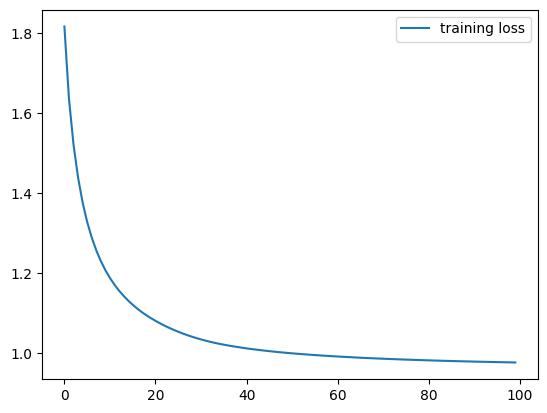

In [12]:
# Autoencoder
n_hidden = 1
ks = 10

model = Autoencoder(num_timesteps=lb, num_inputs=len(cols_n), num_hidden=n_hidden, kernel_size=ks, num_outputs= len(cols), pooling=pooling)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=50, decay_rate=0.97, staircase=True)
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.SGD(learning_rate=lr_schedule), metrics=[tf.metrics.MeanSquaredError(), ])
model.run_eagerly = True
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')
history = model.fit(is_data, epochs=100, callbacks=[early_stopping])
model.summary()

fig, axs = plt.subplots()
axs.plot(history.history['loss'])
# axs.plot(history.history['val_loss'])
# axs.legend(['training loss', 'validation loss'])
axs.legend(['training loss'])

## Denoised Dataset


### Test 1
Close but doesn't look denoised!

In [39]:
window2 = WindowGenerator(input_width=lb, label_width=lb, shift=0, input_columns=cols, label_columns=cols)
td_no_noise = window2.make_dataset(train_df)

mp = int(lb/pooling/2) - 1
y_true_NOnoise = np.concatenate([y for x, y in td_no_noise], axis=0)
y_true_NOnoise_df = pd.DataFrame(y_true_NOnoise[:,mp,:]) # dataframe with no noise
y_true_NOnoise_df.columns = cols

middle = model.encoder(y_true_NOnoise)
middle_df = pd.DataFrame(y_true_NOnoise[:,mp,:])
middle_df.columns = cols
middle_df

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_OIL,_MKT,_VA,_GR,PEg,RVg,GDPg,CAPEg,NewsSent,VIX
0,-0.116249,-1.067653,-1.018331,2.066214,0.935717,-0.008540,2.015927,1.293067,1.867542,1.947829,...,0.382448,-1.170864,-0.086178,-0.088602,-0.829140,-0.033189,0.005360,-1.137812,-0.498968,0.794006
1,-0.163688,-1.163753,-1.104454,2.229420,0.883431,0.517866,1.920820,1.293067,1.775720,1.960666,...,2.895924,-1.181270,-0.006557,-0.261165,-1.118456,-0.033662,0.005360,-1.537323,-0.800631,6.557163
2,-0.163688,-1.259853,-1.166241,2.392626,1.097327,0.624673,1.902933,1.293067,1.834657,2.102996,...,2.804531,-1.179412,-0.086178,-0.088602,-1.147643,-0.033018,0.005360,-1.148511,-1.054750,1.004602
3,-0.163688,-1.355952,-1.222053,2.537697,1.121093,0.922206,1.993241,1.206102,1.903417,2.169975,...,1.484892,-1.099833,-0.086178,-0.088602,-1.178429,-0.032804,-0.427051,-1.066321,-1.268276,0.338005
4,-0.163688,-1.524127,-1.340381,2.882243,1.218535,1.444798,1.980589,1.206102,1.981146,2.309513,...,1.466346,-2.311732,-0.086178,-0.088602,-2.101210,-0.033383,0.005360,-2.284987,-1.463353,-0.979277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,-0.625610,-0.178729,-0.363592,0.089611,-0.656619,-0.145863,-1.318074,-1.157337,-1.414143,-1.297844,...,0.469012,1.264418,1.191981,1.164257,1.342732,-0.030994,0.005360,1.285249,0.517712,-0.069462
1199,-0.630530,-0.154704,-0.345231,0.035209,-0.575814,-0.855367,-1.323746,-1.161478,-1.433789,-1.359799,...,0.342105,0.212124,0.250372,0.189028,0.196686,-0.032597,0.005360,0.230152,0.395998,-1.290578
1200,-0.630530,-0.202754,-0.348582,0.035209,-0.537788,-0.637938,-1.325927,-1.161478,-1.436779,-1.322402,...,-0.631087,-0.088937,-0.107848,-0.010002,-0.462885,-0.033946,0.005360,-0.072161,0.206604,-0.182430
1201,-0.609127,-0.226779,-0.321040,0.017075,-0.530658,-0.958359,-1.319383,-1.161478,-1.438060,-1.298402,...,0.372240,0.395103,0.239740,0.574839,-0.245721,-0.039231,0.005360,0.356285,0.140082,-1.051133


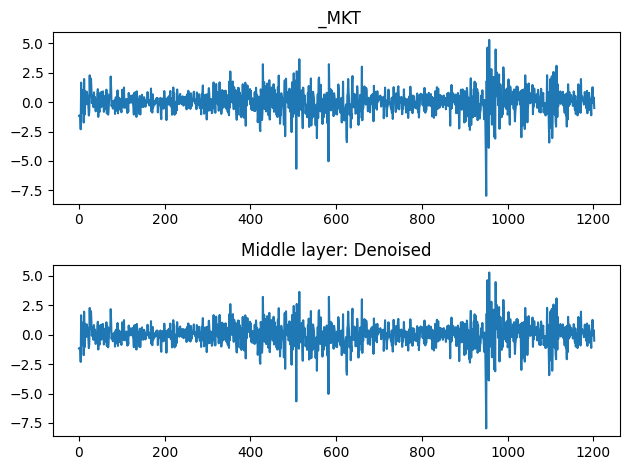

In [40]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(y_true_NOnoise_df['_MKT'])
plt.title(' _MKT')

plt.subplot(2,1,2)
plt.plot(middle_df['_MKT'])
plt.title('Middle layer: Denoised')
plt.tight_layout()
plt.show()

### Test 2
Doesn't make sense

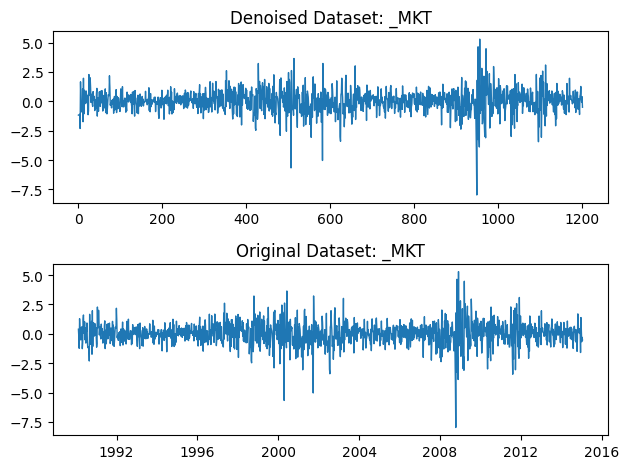

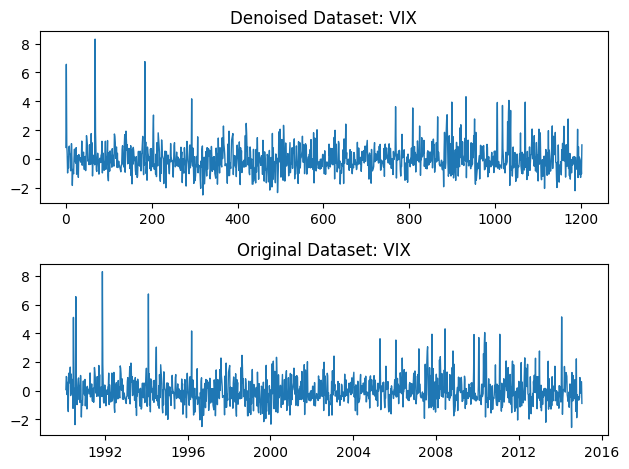

In [26]:
window2 = WindowGenerator(input_width=lb, label_width=lb, shift=0, input_columns=cols, label_columns=cols)
td_no_noise = window2.make_dataset(train_df)

mp = int(lb/pooling/2) - 1
y_true_NOnoise = np.concatenate([y for x, y in td_no_noise], axis=0)
y_true_NOnoise = pd.DataFrame(y_true_NOnoise[:,mp,:]) # dataframe with no noise
y_true_NOnoise.columns = cols


# Plot: _MKT
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_true_NOnoise['_MKT'], linewidth = 1)
plt.title('Denoised Dataset: _MKT')

plt.subplot(2,1,2)
plt.plot(train_df['_MKT'], linewidth = 1)
plt.title('Original Dataset: _MKT')

plt.tight_layout()
plt.show()

# Plot: VIX
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_true_NOnoise['VIX'], linewidth = 1)
plt.title('Denoised Dataset: VIX')

plt.subplot(2,1,2)
plt.plot(train_df['VIX'], linewidth = 1)
plt.title('Original Dataset: VIX')

plt.tight_layout()
plt.show()





### Test 3
Not what we want

3/3 [==============================] - 0s 27ms/step


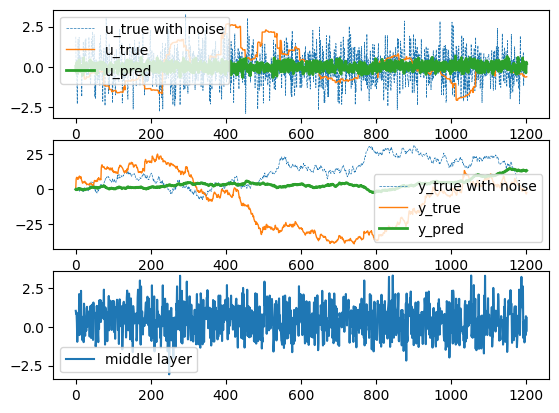

In [27]:
y_pred = model.predict(is_data)
u_true = np.concatenate([x for x, y in is_data], axis=0)
y_true = np.concatenate([y for x, y in is_data], axis=0)
data_true = np.concatenate([y for x, y in is_data], axis=0)
u_true_no_noise = np.concatenate([x for x, y in td_no_noise], axis=0)

plt.figure()
plt.subplot(3,1,1)
mp = int(lb/pooling/2) -1
plt.plot((u_true[:, mp, 0]),'--', linewidth = .5)
plt.plot((u_true_no_noise[:, mp, 0]), linewidth = 1)
plt.plot((y_pred[:, mp, 0]), linewidth = 2)
plt.legend(['u_true with noise', 'u_true', 'u_pred'])

plt.subplot(3,1,2)
plt.plot(np.cumsum(u_true[:, mp, -1]),'--',linewidth = .5)
plt.plot(np.cumsum(u_true_no_noise[:, mp, -1]),linewidth = 1)
plt.plot(np.cumsum(y_pred[:, mp, -1]), linewidth = 2)
plt.legend(['y_true with noise', 'y_true', 'y_pred'])

# Middle layer containing denoised data
middle = model.encoder(u_true)
plt.subplot(3,1,3)
plt.plot((pd.DataFrame(middle[:,mp,-1])))
plt.legend(['middle layer'])

# pd.DataFrame(y_pred[:, mp, :], index = df.index[lb-1:]).to_excel('data_denoised.xlsx')
plt.show()